In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix

13825
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

path_save_ = "./jupyter-notebooks/tests/results-hamiltonian/"

In [ ]:
for i in range(10):
    plt.close()

In [48]:
# -----------------------------------------------------------------
# --- EXAMPLE 1: i d y(t,x) / d t = y(t,x) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

nt = 10
nx = 6

t_max = 12
x_max = 1

Nt = 1 << nt
Nx = 1 << nx

t = np.linspace(0, t_max, Nt)
dt = np.diff(t)[0]
x = np.linspace(0, x_max, Nx)
dx = np.diff(x)[0]

# simulated signal:
y = np.zeros((Nt, Nx), dtype=complex)

# # set the initial signal:
# id_x = 1 << (nx-1)  # X-gate at the most significant qubit;
# y[0,id_x] = 1.0

# *** Set the initial signal ***
delta_gauss = 0.2
x_center = 0.5
id_x = 1 << (nx-1)  # X-gate at the most significant qubit;
for ii in range(Nx):
    y[0,ii] = np.exp(-(x[ii] - x_center)**2/(2.*delta_gauss**2))
    
norm_coef = np.sqrt(np.trapz(np.abs(y[0,:])**2, dx=dx))
y[0,:] = y[0,:] / norm_coef
print("norm coef: {:0.3e}".format(norm_coef))
print("sum y(t = 0)**2: {:0.3e}".format(np.trapz(np.abs(y[0,:])**2, dx=dx)))

# *** Form the Hamiltonian for the system i d y / d t = y ***
H = np.ones((Nx, Nx), dtype=complex)
for ir in range(Nx):
    for ic in range(Nx):
        H[ir, ic] = 1.0

# *** Compute the time evolution of y ***
oo = RK45(
    lambda t,y: -1j*y, 
    t[0], 
    y[0,:], t[-1], first_step=dt, max_step=dt
)

Nt_act = 0
while mix.compare_two_strings(oo.status, "running"):
    oo.step()
    Nt_act += 1
    if Nt_act - 1 == Nt:
        print(oo.t)
    y[Nt_act-1,:] = oo.y
print("sum y(t = t_max)**2: {:0.3e}".format(np.trapz(np.abs(y[-1,:])**2, dx=dx)))
    
del ii, ir


# ---------------------------------------------------------------------------------------------------
# --- Plot psi_tx_matrix(t,x) ---
# ---------------------------------------------------------------------------------------------------
XX, YY = np.meshgrid(t, x)

fig_tx = plt.figure()
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, np.transpose(y.real), levels=100, cmap=cmap_two_signs_)
fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$real\ y$')
# ax.set_ylim(0.0, 1.5)

fig_tx = plt.figure()
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, np.transpose(y.imag), levels=100, cmap=cmap_two_signs_)
fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$imag\ y$')
# ax.set_ylim(0.0, 1.5)


# ---------------------------------------------------------------------------------------------------
# --- Plot psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
t_moments = [10, 80,-1] 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y.real[0,:], color='b', linewidth = 2, linestyle='-', label="t = {:0.3f}".format(t[0]))

counter = 0
for it_ind in t_moments:
    counter += 1
    ax.plot(
        x, y.real[it_ind,:], 
        color=colors_[counter], linewidth = 2, linestyle='-', label="t = {:0.3f}".format(t[it_ind])
    )
del counter
# plt.xlim([0,2])

plt.xlabel('$x$')
plt.ylabel("$real\ y$")
ax.legend()
plt.grid(True)
plt.show()

norm coef: 5.953e-01
sum y(t = 0)**2: 1.000e+00
sum y(t = t_max)**2: 1.000e+00


sum y(t = t_max)**2: 1.000e+00

--- Initial state vector ---
 0.632+0.000j  0.775+0.000j 

*** Original Hamiltonian ***
--- 0 ---
 0.100+0.000j  0.000-0.800j
--- 1 ---
 0.000+0.800j  0.400+0.000j

*** Normalized Hamiltonian ***
--- 0 ---
 0.050+0.000j  0.000-0.400j
--- 1 ---
 0.000+0.400j  0.200+0.000j

//--- The angle for the initialization circuit ---
ay_init  1.772154247585e+00

//--- The angles for the BE oracle ---
ay_H00  2.941257811267e+00
ay_H01  1.287002217587e+00
az_H01  3.141592653590e+00
ay_H10  1.287002217587e+00
az_H10  -3.141592653590e+00
ay_H11  2.318558961455e+00


<IPython.core.display.Javascript object>


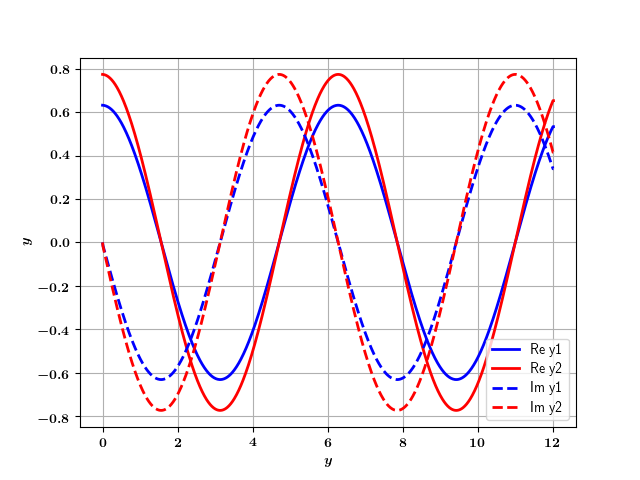

In [107]:
# -----------------------------------------------------------------
# --- EXAMPLE 2: 
# --- i d y1(t) / d t =    a1 * y1 - 1j*b * y2 ---
# --- i d y2(t) / d t =  1j*b * y1 +   a2 * y2 ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

nt = 10
t_max = 12

a1 = 0.1
a2 = 0.4
b  = 0.8

Nt = 1 << nt
t = np.linspace(0, t_max, Nt)
dt = np.diff(t)[0]

# simulated signals:
Ns = 2
y = np.zeros((Nt,Ns), dtype=complex)

# *** Set the initial signal ***
y[0,0] = np.sqrt(0.4)
y[0,1] = np.sqrt(0.6)

# *** Compute the time evolution ***
oo = RK45(
    lambda t,y: -1j*y, 
    t[0], 
    y[0,:], t[-1], first_step=dt, max_step=dt
)

Nt_act = 0
oo.step() # skip one time step
while mix.compare_two_strings(oo.status, "running"):
    oo.step()
#     print(oo.t)
    Nt_act += 1
    y[Nt_act,:] = oo.y
print("sum y(t = t_max)**2: {:0.3e}".format(np.sum(np.abs(y[-1,:])**2)))


# ---------------------------------------------------------------------------------------------------
# --- Compute angles for initialization and block-encoding ---
# ---------------------------------------------------------------------------------------------------

print()
print("--- Initial state vector ---")
mix.print_array(y[0,:])

# *** Form the Hamiltonian for the system ***
H = np.ones((2, 2), dtype=complex)
H[0,0] = a1
H[0,1] = -1j*b
H[1,0] = 1j*b
H[1,1] = a2

print()
print("*** Original Hamiltonian ***")
mix.print_matrix(H)

# *** Normalize the Hamiltonian ***
nonsparsity = 2
rows_sum = np.zeros(2)
for ir in range(Ns):
    rows_sum[ir] = np.sqrt(np.sum(np.abs(H[ir,:])**2))
coef_norm_H = np.max(rows_sum)
H = H / nonsparsity
if coef_norm_H > 1:
    H = H / coef_norm_H

print()
print("*** Normalized Hamiltonian ***")
mix.print_matrix(H)


# *** Compute angles ***
ay_init = 2*np.arccos(y.real[0,0])  # Ry(ay_init_y1)*|0>

coef_OF = nonsparsity # take into account the action of the oracle OH
ay_H00, az_H00 = mix.calc_angles_from_a_value(H[0,0] * coef_OF)
ay_H01, az_H01 = mix.calc_angles_from_a_value(H[0,1] * coef_OF)
ay_H10, az_H10 = mix.calc_angles_from_a_value(H[1,0] * coef_OF)
ay_H11, az_H11 = mix.calc_angles_from_a_value(H[1,1] * coef_OF)


print()
print("//--- The angle for the initialization circuit ---")
print("ay_init  {:0.12e}".format(ay_init))
    
print()
print("//--- The angles for the BE oracle ---")
print("ay_H00  {:0.12e}".format(ay_H00))
if az_H00 is not None:
    print("az_H00  {:0.12e}".format(az_H00))
    
print("ay_H01  {:0.12e}".format(ay_H01))
if az_H01 is not None:
    print("az_H01  {:0.12e}".format(az_H01))
    
print("ay_H10  {:0.12e}".format(ay_H10))
if az_H10 is not None:
    print("az_H10  {:0.12e}".format(az_H10))
    
print("ay_H11  {:0.12e}".format(ay_H11))
if az_H11 is not None:
    print("az_H11  {:0.12e}".format(az_H11))


# ---------------------------------------------------------------------------------------------------
# --- Plot y1(t) and y2(t) ---
# ---------------------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t, y.real[:,0], "-b", linewidth = 2, label="Re y1")
ax.plot(t, y.real[:,1], "-r", linewidth = 2, label="Re y2")

ax.plot(t, y.imag[:,0], "--b", linewidth = 2, label="Im y1")
ax.plot(t, y.imag[:,1], "--r", linewidth = 2, label="Im y2")

# plt.xlim([0,2])

plt.xlabel('$y$')
plt.ylabel("$y$")
ax.legend()
plt.grid(True)
plt.show()

In [93]:
np.sqrt(0.1**2 + 0.8**2)

0.806225774829855

In [90]:
np.sqrt(np.sum(np.abs(H[0,:])**2))

0.806225774829855

In [92]:
np.abs(H[0,:])

array([0.1, 0.8])

In [103]:
ay_init

0.8860771237926136

In [104]:
np.cos(ay_init)

0.6324555320336759